Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data



Importing all the important libraries


In [144]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os

%matplotlib inline


In [145]:
## mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


*   Data Reading/Data Understanding

The data set contains Train and Test Data Sets which have 9 folders each depicting 9 types of cancer

In [146]:
# Defining the path for train and test images
train_data = pathlib.Path("/content/gdrive/MyDrive/DataSet/Train")
test_data = pathlib.Path('/content/gdrive/MyDrive/DataSet/Test')

In [147]:
image_count_train = len(list(train_data.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.


Create a Dataset

Define some parameters for the loader

In [148]:
batch_size = 32
img_height = 180
img_width = 180

*   Dataset Creation
Using 80% of the images for training, and 20% for validation.

In [149]:
# Training Data Set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [150]:
#Validation Data Set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [151]:
# Listing out all the classes of skin cancer and storing them in a list. 
# Class names being the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


*   Dataset visualisation 

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

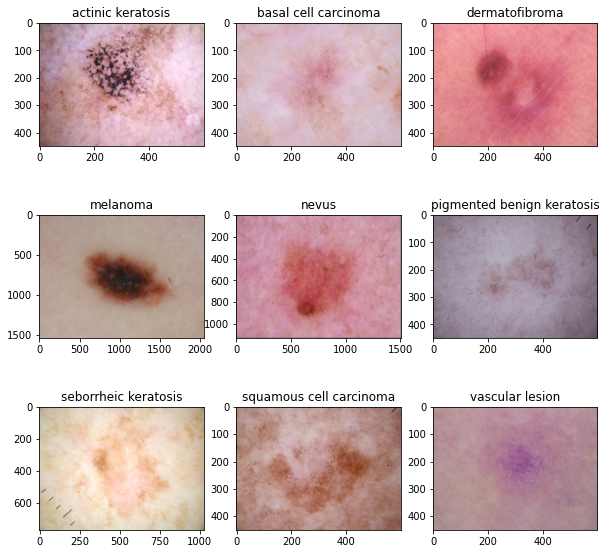

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(train_data.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

plt.show()

In [153]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

*   Model Building & training : 

Problem Statement:

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
Choose an appropriate optimiser and loss function for model training
Train the model for ~20 epochs
Write your findings after the model fit, see if there is evidence of model overfit or underfit

Creating a Model

Model-1:

In [154]:
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 32)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [155]:
# summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_48 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 64)        18496     
                                                     

In [156]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [157]:
# View the summary of all layers
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_48 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 90, 90, 64)        18496     
                                                     

In [158]:
#Training the model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 11s 75ms/step - loss: 3.4830 - accuracy: 0.2031 - val_loss: 2.0695 - val_accuracy: 0.2327
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.9466 - accuracy: 0.2852 - val_loss: 1.8374 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6471 - accuracy: 0.4196 - val_loss: 1.5775 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4684 - accuracy: 0.4844 - val_loss: 1.6053 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3730 - accuracy: 0.5167 - val_loss: 1.4351 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2986 - accuracy: 0.5597 - val_loss: 1.4265 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1792 - accuracy: 0.5871 - val_loss: 1.4768 - val_accuracy: 0.5011
Epoch 8/20
56/56 [=====

Visualizing training results

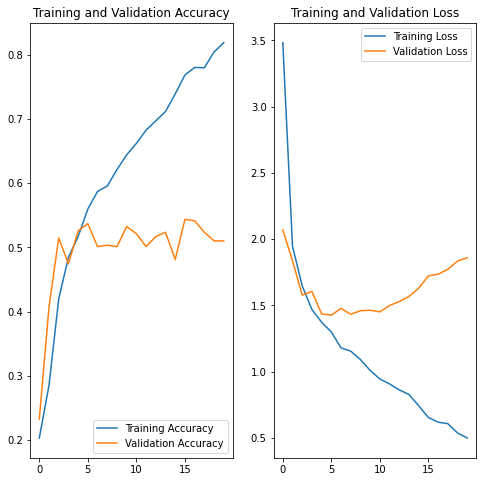

In [159]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As shown from the plots above Training and Validation accuracies and losses start showing differences around the epoch 10



In [160]:
#Finding whether model overfits or underfits

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 13ms/step - loss: 1.8591 - accuracy: 0.5101
Accuracy:  0.8688616156578064
Validation Accuracy:  0.5100671052932739
Loss:  0.43164530396461487
Validation Loss 1.8590760231018066


The accuracy of the model for the Training data set is at 86%. But the Validation accuracy is not at par with the training accuracy. It is at 51%. The validation loss as observed is very high. This could also be indicative of some Overfit in the model. We could add some Dropout layers  and by adding a few more layers, we could improve the accuracy by trying to extract more features.

Problem Statement

*   Choose an appropriate data augmentation strategy to resolve underfitting/overfitting 



In [161]:
# After analysis of the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

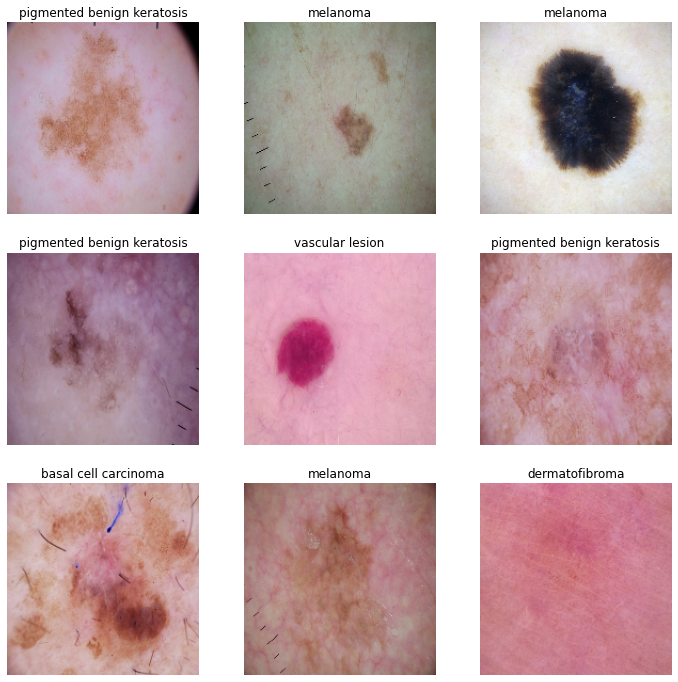

In [162]:
# Visualizing the performance of augmentation strategy for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [163]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




*   Model Building & training on the augmented data :

Problem Statement:

Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
Choose an appropriate optimiser and loss function for model training
Train the model for ~20 epochs
Write your findings after the model fit, see if the earlier issue is resolved or not?










Create the model, compile and train the model

Model 2

In [164]:
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 32)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Compiling the model

In [165]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the Model

In [166]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 3s 47ms/step - loss: 2.6851 - accuracy: 0.2215 - val_loss: 1.9307 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.8068 - accuracy: 0.3510 - val_loss: 1.6760 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6133 - accuracy: 0.4202 - val_loss: 1.4809 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4842 - accuracy: 0.4732 - val_loss: 1.4857 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3683 - accuracy: 0.5162 - val_loss: 1.4175 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 2s 45ms/step - loss: 1.3142 - accuracy: 0.5379 - val_loss: 1.4595 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 45ms/step - loss: 1.2889 - accuracy: 0.5541 - val_loss: 1.4011 - val_accuracy: 0.5056
Epoch 8/20
56/56 [======

Visualizing the results

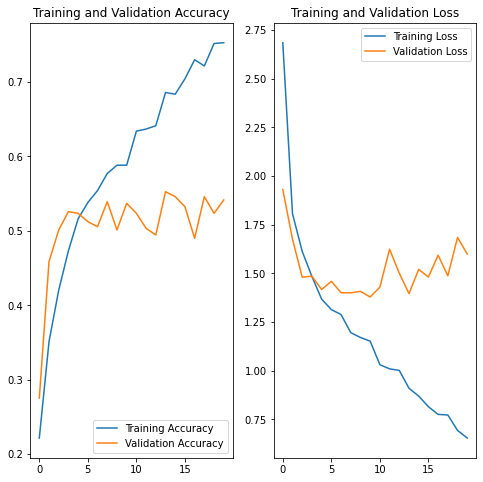

In [167]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [168]:
#Finding whether model overfits or underfits

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 15ms/step - loss: 1.5999 - accuracy: 0.5414
Accuracy:  0.8231026530265808
Validation Accuracy:  0.5413870215415955
Loss:  0.515568196773529
Validation Loss 1.5998979806900024


As shown from the results abpve the model performance has improved as comparred to Model-1 and there has been little improvements over validation loss. Still the model is overfitted.

Problem Statement:

*   Class distribution: Examine the current class distribution in the training dataset 
- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?





In [169]:
##
data_path=[]
scan_list=[]
for i in class_names:
      
    for j in train_data.glob(i+'/*.jpg'):
        data_path.append(str(j))
        scan_list.append(i)
dataframe_dict_original = dict(zip(data_path, scan_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
1,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
2,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
3,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
4,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion
2235,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion
2236,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion
2237,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion


In [170]:
dataframe_dict_original = dict(zip(data_path, scan_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
1,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
2,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
3,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
4,/content/gdrive/MyDrive/DataSet/Train/actinic ...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion
2235,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion
2236,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion
2237,/content/gdrive/MyDrive/DataSet/Train/vascular...,vascular lesion


<BarContainer object of 9 artists>

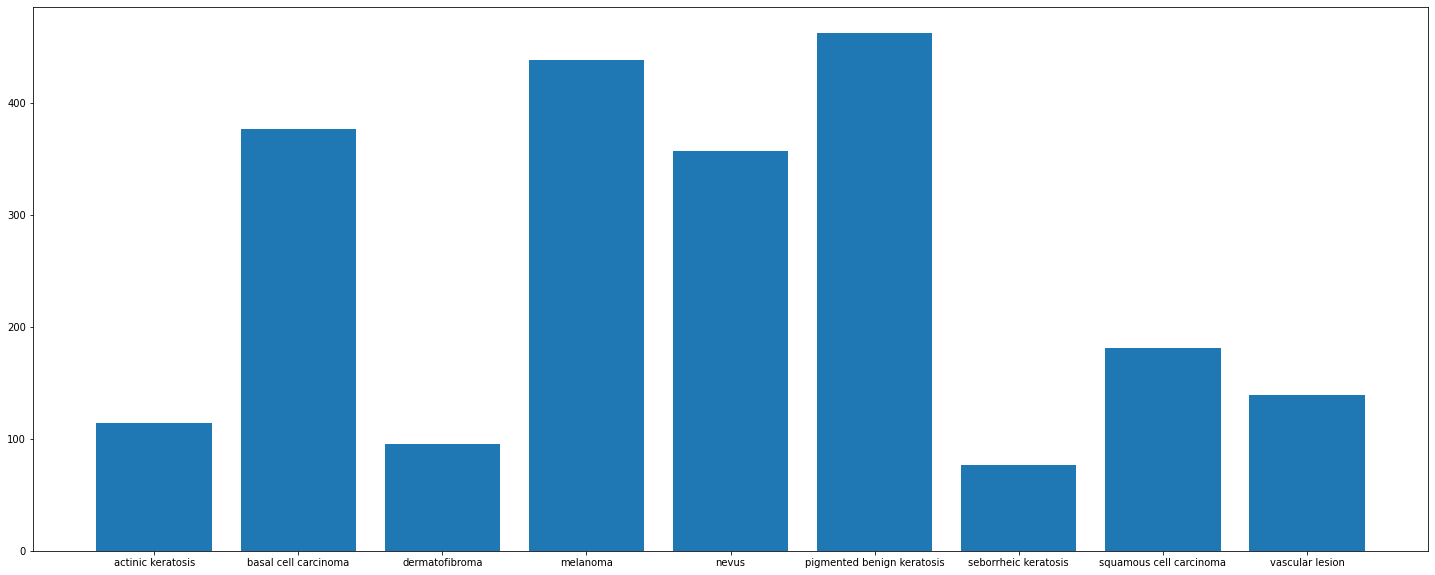

In [171]:
count=[]
for i in class_names:
    count.append(len(list(train_data.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

Findings:
- Which class has the least number of samples?
**Answer**: Sebhhoreic Keratosis has the least number of samples


- Which classes dominate the data in terms proportionate number of samples?
**Answer**: Pigmented Benign Keratosis dominates the data in terms of proportionate number of samples.

In [172]:
import glob
path_list = [x for x in glob.glob(os.path.join(train_data, '*','output', '*.jpg'))]
path_list

[]

Problem Statement:

*   Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.

In [173]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [174]:
path_to_training_dataset="/content/gdrive/MyDrive/DataSet/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB713ED26D0>: 100%|██████████| 500/500 [00:09<00:00, 52.69 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB716B58B90>: 100%|██████████| 500/500 [00:10<00:00, 49.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7162CF710>: 100%|██████████| 500/500 [00:10<00:00, 46.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB716C88E90>: 100%|██████████| 500/500 [00:45<00:00, 11.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB7A00FA750>: 100%|██████████| 500/500 [00:42<00:00, 11.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB716FFEA50>: 100%|██████████| 500/500 [00:08<00:00, 55.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB7160E39D0>: 100%|██████████| 500/500 [00:22<00:00, 22.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7169F5A90>: 100%|██████████| 500/500 [00:09<00:00, 54.14 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/DataSet/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB7A00FAB90>: 100%|██████████| 500/500 [00:09<00:00, 52.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [175]:
image_count_train = len(list(train_data.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [176]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(train_data, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [177]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [178]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [179]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Training the model on the data created using Augmentor

In [180]:
batch_size = 32
img_height = 180
img_width = 180

In [181]:
import pathlib
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/DataSet/Train/")

In [182]:
data_dir_train1

PosixPath('/content/gdrive/MyDrive/DataSet/Train')

Creating a training dataset

In [183]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [184]:
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/DataSet/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [185]:
epochs =30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 20s 116ms/step - loss: 0.9763 - accuracy: 0.6502 - val_loss: 0.9564 - val_accuracy: 0.6734
Epoch 2/30
169/169 [==============================] - 18s 100ms/step - loss: 0.7832 - accuracy: 0.7107 - val_loss: 0.7957 - val_accuracy: 0.6868
Epoch 3/30
169/169 [==============================] - 19s 107ms/step - loss: 0.6487 - accuracy: 0.7630 - val_loss: 0.6542 - val_accuracy: 0.7494
Epoch 4/30
169/169 [==============================] - 16s 90ms/step - loss: 0.5623 - accuracy: 0.7953 - val_loss: 0.5947 - val_accuracy: 0.7740
Epoch 5/30
169/169 [==============================] - 16s 93ms/step - loss: 0.5285 - accuracy: 0.8042 - val_loss: 0.6487 - val_accuracy: 0.7852
Epoch 6/30
169/169 [==============================] - 16s 90ms/step - loss: 0.4733 - accuracy: 0.8277 - val_loss: 0.5504 - val_accuracy: 0.8255
Epoch 7/30
169/169 [==============================] - 16s 91ms/step - loss: 0.3682 - accuracy: 0.8670 - val_loss: 0.4393 - val_accura

Creating a validation dataset

In [186]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [187]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the model (including normalization)

Model-3

In [188]:
from keras.layers import BatchNormalization
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 32)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Applying Batch Normalization
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.1))


model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Applying Batch Normalization
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Applying Batch Normalization
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Compiling the Model

In [189]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the Model

Visualizing the model results

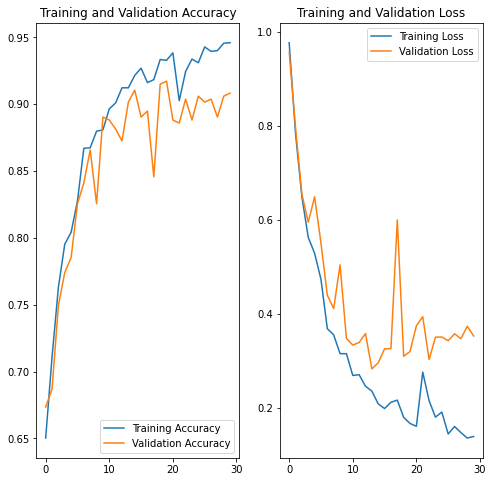

In [190]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the results above, the model has improved performance upon fixing of class imbalance and batch normalization, overfitting is improved, with more number of layers and epochs.